
Si tratta di un compito regressione, in cui l'obiettivo è prevedere l'area bruciata dagli incendi boschivi, nella regione nordorientale del Portogallo, utilizzando dati meteorologici e di altro tipo.
DATASET: Multivariato
AREA TEMATICA: Clima e Ambiente
(Basato su campionu reali)

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions

Import del dataset da file csv come dataframe usando pandas

In [133]:
pd.set_option('display.max_columns', None)

file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)

# Mostra le prime righe del DataFrame
print(df.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


La funzione df.describe() è un metodo molto utile di pandas, una libreria Python per l'elaborazione dei dati. Serve per generare statistiche descrittive di base per le colonne numeriche (o categoriali se specificato) di un DataFrame.

In [134]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Analizzando le statistiche si puo notare come la caratteristica rain ha una media molto piu bassa rispetto il massimo (<< della metà), lo stesso anche per l'output che sembra essere estremamente sbilanciata verso lo zero. una visualizzazione dei dati potrebbe aiutare a capire la distribuzione.

<Axes: xlabel='area', ylabel='Count'>

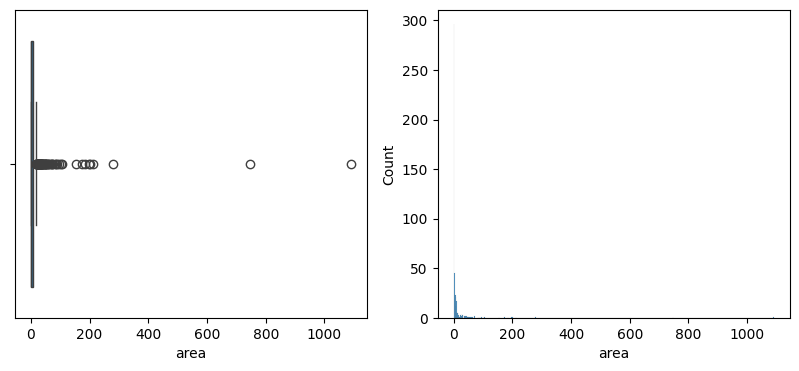

In [135]:

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['area'], kde = False)

Un modo per riportare l'area su una scala migliore è l'utilizzo del logaritmo. Questa tecnica, oltre che ridurre questo sbilanciamento dei dati potrebbe avere, come effetto collaterale, la capacità predittiva del modello.

<Axes: xlabel='log_area', ylabel='Count'>

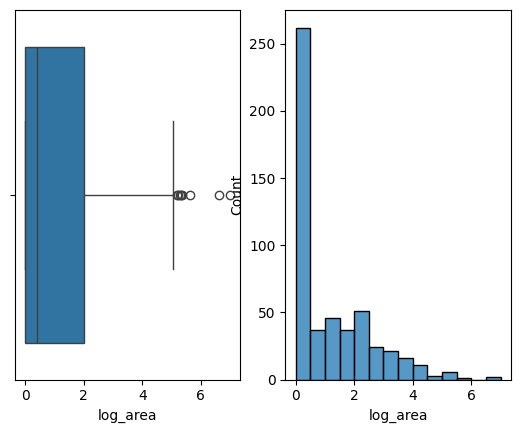

In [136]:
# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['log_area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['log_area'], kde = False)

Ora diamo un'occhiata anche alla variabile 'rain'

<Axes: xlabel='rain', ylabel='Count'>

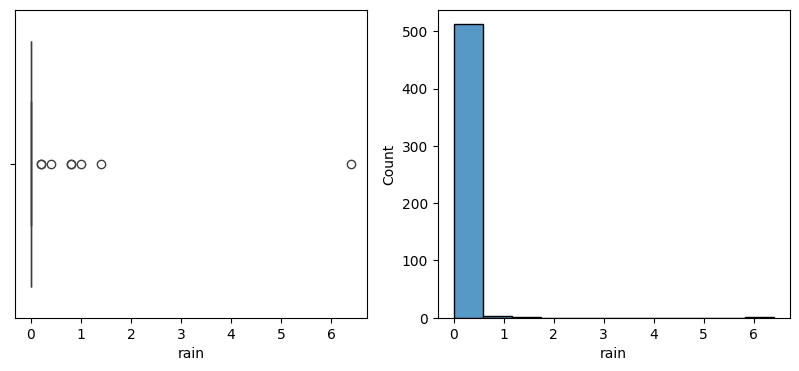

In [137]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['rain']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['rain'], kde = False)

Anche in questo caso i valori sono molto schiacciati verso lo zero... Si può provare anche qui un cambio di scala utilizzando il logaritmo ma non sarebbe opportuno, perchè i valori della pioggia sono fondamentali nell'apprendimento perchè sono una parte fondamentale nella previsione di incendi e il logaritmo ne riduce l'importanza (coerentemente a quanto detto non è opportuno rimuovore gli outliers) 

Ora riproponiamo dati per fare ulteriori analisi sulle variabili stringa

In [138]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000


Chiaramente i mesi e i giorni non sono caratteristiche numerice, quindi vanno codificate. Qui è possibile fare due considerazioni distinte: per i MESI possiamo adottare una codifica ciclica dato che sono essi stessi dei cicli, ma soprattutto generalmente esistono dei mesi piu caldi e piu freddi e questa relazione non è indipendente dai mesi; mentre pwr quanto riguarda i GIORNI si può pensare di utilizzare OneHotEncoding per non aggiungere ulteriori relazioni d'ordine al modello (in qaunto idealmente non necessarie per i giorni).

In [139]:
# CODIFICA MESI
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['Month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno


# CODIFICA GIORNI
enc_oneHot = preprocessing.OneHotEncoder()

arr = enc_oneHot.fit_transform(df[['day']]) 

# Conversione in array denso
dense_array = arr.toarray()
# Recuero nomi per le colonne
col_names = enc_oneHot.get_feature_names_out(['day'])
# Creazione DataFrame dalle colonne codificate da concatenare a quello originale
encoded_df = pd.DataFrame(dense_array, columns=col_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)

df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,month_encoded,Month_encoded_sin,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000,3.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000,10.0,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000,10.0,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000,3.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000,3.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871,8.0,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592,8.0,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152,8.0,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000,8.0,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Un ulteriore passo è la pulizia del DataFrame per rimuovore le colonne che non verranno utilizzate durante l'addestramento

In [140]:
df.drop(columns=['day', 'month', 'area', 'month_encoded'], inplace=True)
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,Month_encoded_sin,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Prima di cercare un modello opportuno e addestrarlo analizzaimo le correlazioni tra le colonne del dataset. Le colonne sottoposte a oneHotEncoding, semplicemente, non verranno considerate, al fine di evitare eventuali correlazioni dovute dalla natura della codifica

<Axes: title={'center': 'Features Correlation'}>

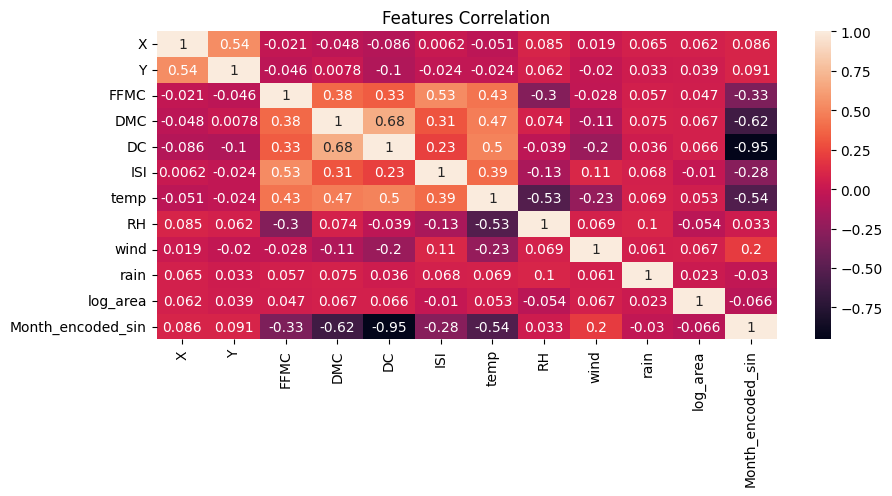

In [141]:
#df without theese two features (species and target)
df_corr = df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'])

plt.figure(figsize=(10,4))
plt.title('Features Correlation')

sns.heatmap(df_corr.corr(), annot=True) # Usa la correlazione di Pearson

Si può notare come il DC è molto correlato ai mesi dell'anno... c'era da aspettarselo vista la natura della caratteristica DC (vedere README).
Prima di effettuare ulteriori manipolazioni del dataset, però, proviamo ad addestrare qualche modello (verrà utilizzato l'argomento random state = 42 per la riproducibilità dei risultati nel confronto tra modelli).

In [ ]:
X = df.drop('log_area', axis=1)  # Features
y = df['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Valutazione performace

# MAE.
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

# MSE
print('Mean Squared Error:', (root_mean_squared_error(y_test,y_pred))**2)
# RMSE = SQRT di MSE
print('Root Mean Squared Error:', root_mean_squared_error(y_test,y_pred))


# Intervalli per la tolleranza dell'errore (in %)
tolerances = [0.05,0.1,0.3] 

for tolerance in tolerances:
    # Calcolare l'errore relativo (errore assoluto / valore reale)
    err_rel = np.abs(y_test - y_pred) / y_test # (/ y_test) -> per normalizzare

    # Verifica quante previsioni sono accettabili (errore relativo <= tolleranza)
    acceptable_predictions = err_rel <= tolerance

    # Calcolare la percentuale di previsioni accettabili
    accuracy_percentage = np.mean(acceptable_predictions) * 100

    # Stampa l'accuratezza in percentuale
    print(f'Accuracy in percentage (with a tolerance of {tolerance * 100}%): {accuracy_percentage:.2f}%')


Mean Absolute Error: 1.20455112823936
Mean Squared Error: 2.2094640537359886
Root Mean Squared Error: 1.4864266055665138
Accuracy in percentage (with a tolerance of 5.0%): 50.96%
Accuracy in percentage (with a tolerance of 10.0%): 50.96%
Accuracy in percentage (with a tolerance of 30.0%): 50.96%
